In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

import sys
sys.path.insert(0, '/Users/zgubic/Projects/FairMass/fairmass')
import models

In [2]:
def plot_MI(gen_x, gen_y, n_epochs=200, H=20, name='name'):

    # prepare the placeholders for inputs
    x_in = tf.placeholder(tf.float32, [None, 1], name='x_in')
    y_in = tf.placeholder(tf.float32, [None, 1], name='y_in')

    # make the loss and optimisation graphs
    T_xy, T_x_y, mine_vars = models.MINE(x_in, y_in, name, deep=False)
    neg_loss = models.MINE_loss(T_xy, T_x_y)
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)
    
    deep_T_xy, deep_T_x_y, deep_mine_vars = models.MINE(x_in, y_in, 'deep_'+name, deep=True)
    deep_neg_loss = models.MINE_loss(deep_T_xy, deep_T_x_y)
    deep_opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(deep_neg_loss)
    
    # run the session and training
    sess.run(tf.global_variables_initializer())

    # train
    MIs = []
    deep_MIs= []
    for epoch in range(n_epochs):
        x_sample=gen_x()
        y_sample=gen_y(x_sample)
    
        feed_dict = {x_in:x_sample, y_in:y_sample}
        _, _, neg_l, deep_neg_l = sess.run([opt, deep_opt, neg_loss, deep_neg_loss], feed_dict=feed_dict)
    
        MIs.append(-neg_l)
        deep_MIs.append(-deep_neg_l)

    # compute true MI
    x=gen_x()
    y=gen_y(x)
    mi = mutual_info_regression(x.reshape(-1, 1), y.ravel())[0]
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # data
    ax[0].scatter(x, y, marker='x')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    # MINE performance
    ax[1].plot(range(len(MIs)), MIs, label='MINE estimate')
    ax[1].plot(range(len(deep_MIs)), deep_MIs, label='deep MINE estimate')
    ax[1].plot([0, len(MIs)], [mi,mi], label='True MI')
    ax[1].set_title('MINE for {}'.format(name))
    ax[1].set_xlabel('training steps')
    ax[1].set_ylabel('MI (loss)')
    ax[1].legend(loc='best')
    fig.show()

In [3]:
sess = tf.InteractiveSession()

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/zgubic/anaconda3/

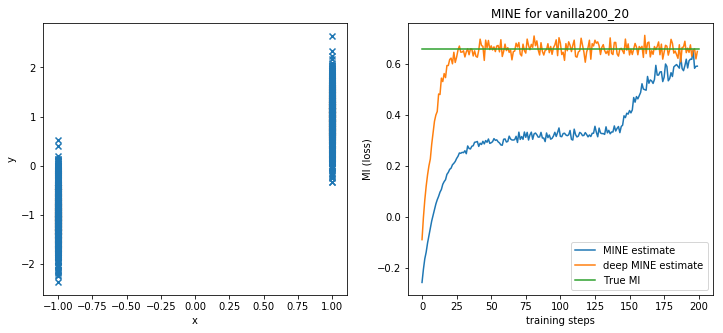

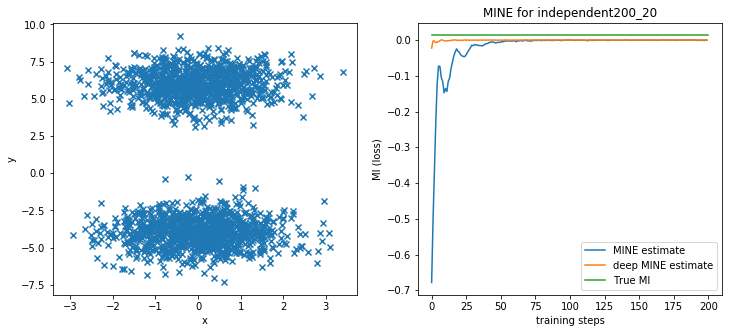

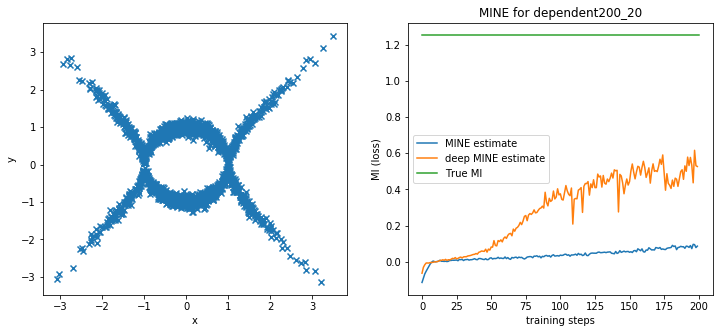

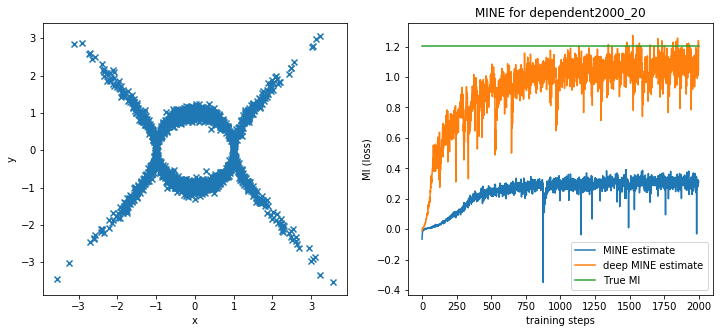

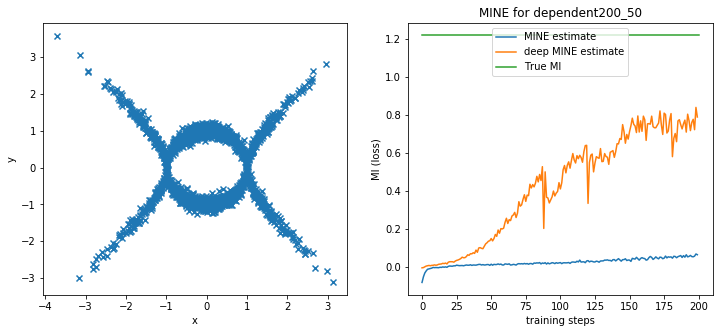

In [4]:
data_size = 2000

# vanilla option
def gen_x():
    vec =  np.sign(np.random.normal(0.,1.,[data_size,1]))
    return(vec)
def gen_y(x):
    vec =  x + np.random.normal(0.,np.sqrt(0.2),[data_size,1])
    return vec
plot_MI(gen_x, gen_y, 200, 20, 'vanilla200_20')

# independent
def gen_ind_x():
    return np.random.normal(0, 1, data_size).reshape(-1, 1)
def gen_ind_y(_):
    vec = np.random.normal(1, 1, data_size) + 10 * (0.5 - np.random.binomial(1, 0.5, size=data_size))
    return vec.reshape(-1, 1)
plot_MI(gen_ind_x, gen_ind_y, 200, 20, 'independent200_20')
    
# harder (more spread)
def gen_dep_x():
    return np.random.normal(0, 1, data_size).reshape(-1, 1)
def gen_dep_y(x):
    N = data_size
    vec =  np.random.normal(0, 0.1, N) + 2*(0.5 - np.random.binomial(1, 0.5, size=N)) * np.abs(1-x.ravel()**2)**0.5
    return vec.reshape(-1, 1)
plot_MI(gen_dep_x, gen_dep_y, 200, 20, 'dependent200_20')
plot_MI(gen_dep_x, gen_dep_y, 2000, 20, 'dependent2000_20')
plot_MI(gen_dep_x, gen_dep_y, 200, 50, 'dependent200_50')
